**ML for LFT in a Nutshell**
----

Recall the following map from Prof. Cheng's lecture this morning.
![picture](https://drive.google.com/uc?export=view&id=14eZSrjzaRHuz4Rtf3hAqyJ0uu6QW2dTS)
Our endgoal is to generate samples from a target distribution $p(\phi) = \frac{e^{-S[\phi]}}{Z}$.
* Action $S[\phi]$ in exponent is determined by the physics problem at hand. E.g. the action for interacting scalar field theory on lattice is  $$S[\phi] = \sum\limits_{x,y \in V_L} \phi_x \, \Delta_{x,y} \, \phi_y + \sum\limits_{x \in V_L} (m^2 \phi_x^2 + \lambda \phi^4_x) ,$$ at leading order.
* $Z$ is an appropriate normalization constant.

Let us consider the simplest ML approch to generate target distribution $p(\phi)$.
* Initialize a Neural Network with parameters $\theta$ sampled from some initial distribution $Q_{\theta}$, and inputs are $x, y \in V_L$. Then outputs are drawn from initial distribution $Q(x)$.
* In general, the target distribution $p(\theta)$ requires entirely different choice for network parameter distributions. Let us label this intended distribution as $P_{\theta}$.
* Network outputs for parameters sampled from $P_{\theta}$, and inputs $x, y \in V_L$, are labelled as $P(x)$.
* Training updates distribution $Q_{\theta}$ until the difference between distributions $P(x)$ and $Q(x)$ is minimized.

**We need a good loss function**
----

* An ideal loss function will minimize differences between two probability distributions, of the forms $P(x) \sim e^{- S_P(x)}$ and $Q(x) \sim e^{- S_Q(x)}$.
* If the loss function involves logarithms of $P(x)$ and $Q(x)$, then evaluating derivatives of the loss function becomes easier.

KL or Kullback-Leibler divergence makes a good loss function, for problems of this nature.




**Kullback-Leibler diveregnce:**
---

It's a statistical measure of how much the probability distributions of two events differ from each other, or how much entropy is gained or lost in changing one probability distributon to the other.


> Suppose, $Q(x)$ and $P(x)$ denote the probability distributions of *approximate* and *target* distributions $Q$ and $P$ on some space $x$. Then the KL divergence loss from $Q$ to $P$ is given by
$$D_{KL}(P || Q) = - \sum_{x \in X} P(x) \log\bigg(\frac{Q(x)}{P(x)} \bigg) .$$
Note that $D_{KL}(P||Q) \neq D_{KL}(Q || P)$, so KL divergence does not play the role of actual distance.


---
**Example 0:**
---


Let us demonstrate how the KL divergence between two distributions are calculated numerically. To keep life simple, we will call the function [*losses.KLDivergence*](https://www.tensorflow.org/api_docs/python/tf/keras/losses/KLDivergence) from "*keras*" library in "*Tensorflow*", and use it to directly compute the KL divergence between two data sets.  

We break this down into the following steps:

*   Import libraries necessary to calculate KL divergence.



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

*   Define any two distributions. I am defining target distribution $P$ and approximate distribution $Q$ as two arrays. If you want to try something different, choose any $P$ and $Q$ from the same 2D or 3D Gaussian distribution, and compute the KL divergence between them.



In [ ]:
# True distribution P_x and approximate distribution Q_x
P_x = [[-0.4, 1], [3, 0.2]]
Q_x = [[0.16, 0.4], [0.14, 2.1]]

* Next, the function [*losses.KLDivergence*](https://www.tensorflow.org/api_docs/python/tf/keras/losses/KLDivergence) takes in two arguments - 1) reduction, and 2) name. We need to specify "*name=kl_divergence*", and for reduction, we want something that will sum over the batch size (to keep our ML spirit up). The choice for summing over batch size is "*reduction=auto*", used here.

In [ ]:
tf.keras.losses.KLDivergence(reduction="auto", name="kl_divergence")
kl = tf.keras.losses.KLDivergence()
kl(P_x, Q_x).numpy()

1.2802572




---


**Example 1: Let us use KL divergence loss function for CIFAR10 image classification.**
---

First, walk through the following steps to define train data and test data from CIFAR10, and then initialize a simple CNN. We will utilize Keras library in Tensorflow for this example, as its prebuilt functions are helpful for beginners.





*   First, we import the libraries that we need.



In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K

*   Given below are model configurations. One can choose differently, I encourage you to play with these attributes at a later time.



In [ ]:
img_width, img_height         = 32, 32
batch_size                    = 250
no_epochs                     = 25
no_classes                    = 10
validation_split              = 0.4
verbosity                     = 1

* Load CIFAR10 dataset as train and test data.

In [ ]:
(i_train, o_train), (i_test, o_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


* We need to reshape data based on channels first / channels last strategy.

In [ ]:
if K.image_data_format() == 'channels_first':
    i_train = i_train.reshape(i_train.shape[0],3, img_width, img_height)
    i_test = i_test.reshape(i_test.shape[0], 3, img_width, img_height)
    i_shape = (3, img_width, img_height)
else:
    i_train = i_train.reshape(i_train.shape[0], img_width, img_height, 3)
    i_test = i_test.reshape(i_test.shape[0], img_width, img_height, 3)
    i_shape = (img_width  , img_height, 3)


* We want all numbers as floats.

In [ ]:
i_train = i_train.astype('float32')
i_test = i_test.astype('float32')

* The test and train data require an appropriate normalization.

In [ ]:
i_train = i_train / 255
i_test = i_test / 255

* Next, we need to convert target vectors to categorical targets.

In [ ]:
o_train = keras.utils.to_categorical(o_train, no_classes)
o_test = keras.utils.to_categorical(o_test, no_classes)

* A CNN model is defined below. You can add or remove layers, or change layer sizes, or activation functions, if you want.

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='tanh', input_shape=i_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.70))
model.add(Flatten())
model.add(Dense(64, activation='exponential'))
model.add(Dense(no_classes, activation='softmax'))

* Next, it is time to train the CNN! There are two steps to this.
 * **First**, we need to "*compile*" the model, where we specify the **loss function** and the optimizer. These choices are used for training. We will use the function, given below, for compiling the CNN.
```
model.compile(loss= ,optimizer= ,metrics= )  
```
  Here, we will define a custom KL divergence loss function, instead of calling the inbuilt KL divergence loss ```keras.losses.kullback_leibler_divergence```. To keep life simple, we will choose ```optimizer=keras.optimizers.Adam()``` and ```metrics=['accuracy']```, respectively.

 * **Next**, we need to train the CNN. For this, we will use
```
model.fit(X, Y, epochs= , batch_size= , verbose= , validation_split= )
```
where ```X``` and ```Y``` are model inputs and outputs.

  One can obtain training history using *.History()*. Moreover, the train and test loss and accuracies can be obtained using *.history['loss']*, *.history['val_loss']*, *.history['accuracy']*, and *.history['val_accuracy']*, respectively.

**Exercise 1: Define a KL loss function to compile this CNN, and then train it. Plot the loss and accuracies for train and test data sets.**
---

**Solution (To be removed before GitHUb upload)**
---

Epoch 1/25
200/200 [==============================] - 122s 599ms/step - loss: 1.7392 - accuracy: 0.3693 - val_loss: 1.4109 - val_accuracy: 0.5029
Epoch 2/25
200/200 [==============================] - 117s 583ms/step - loss: 1.3888 - accuracy: 0.5032 - val_loss: 1.2258 - val_accuracy: 0.5784
Epoch 3/25
200/200 [==============================] - 115s 575ms/step - loss: 1.2698 - accuracy: 0.5490 - val_loss: 1.1447 - val_accuracy: 0.5978
Epoch 4/25
200/200 [==============================] - 118s 590ms/step - loss: 1.1900 - accuracy: 0.5777 - val_loss: 1.0889 - val_accuracy: 0.6196
Epoch 5/25
200/200 [==============================] - 133s 666ms/step - loss: 1.1328 - accuracy: 0.6001 - val_loss: 1.0235 - val_accuracy: 0.6438
Epoch 6/25
200/200 [==============================] - 128s 639ms/step - loss: 1.0926 - accuracy: 0.6124 - val_loss: 0.9973 - val_accuracy: 0.6517
Epoch 7/25
200/200 [==============================] - 132s 655ms/step - loss: 1.0562 - accuracy: 0.6257 - val_loss: 0.9660 -

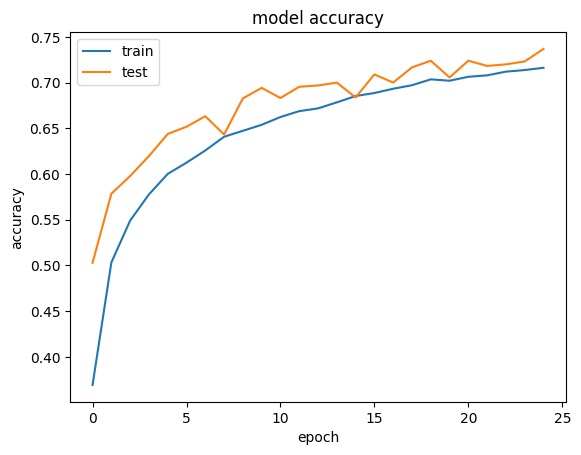

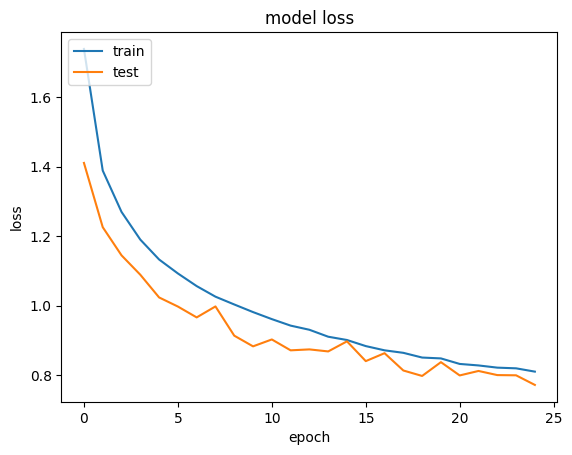

In [ ]:
# define the custom KL divergence loss
def my_KL_loss_fn(y_true, y_pred):
    return tf.reduce_sum(-tf.math.multiply_no_nan(x=y_true,y=(tf.math.log(y_pred  + 1e-3) - tf.math.log(y_true + 1e-3) )), axis=-1) # an upper cap of 1e-3 is added in argument of log(y_true) to ensure we don't get NANs from log(0)

# compile the CNN
model.compile(loss=my_KL_loss_fn,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# train the CNN
model_history = model.fit(i_train, o_train,
      batch_size=batch_size,
      epochs=no_epochs,
      verbose=verbosity,
      validation_data=(i_test, o_test),
      validation_split=validation_split
)

import matplotlib.pyplot as plt

# plot accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plot loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


**Forward and Reverse KL divergences:**
---

$D_{KL}(P||Q)$ and $D_{KL}(Q||P)$ are respectively known as the Forward and Reverse KL divergences for true and approximate distributions $P(x)$ and $Q(x)$.

In the case of Forward KL divergence, $P(x) = 0$ does not contribute towards minimizing the loss, and $Q(x)$ is updated to approximate those data points for which $P(x)>0$. Thus, Forward KL divergence may not result in the best approximate distribution $Q(x)$, at the end of training.

> Let us demonstrate this pictorially --
![picture](https://drive.google.com/uc?export=view&id=15HnW-cd2QInRNP5LapvvPlTyGYCq-XiI)
* P(x) is our target distribution.
* Q(x) is the initial distribution, before we start training.
* Using Forward KL divergence, the NN model learns to approximate for any $P(x)>0$, such approximation is bad here.
* We obtain the following Q(x).
![picture](https://drive.google.com/uc?export=view&id=1j-hZ-Co_R_eaECTUJPWmrtts31WjePiB)
* Not the final approximate distribution we would like.


On the other hand, the *Reverse KL divergence* $$D_{KL}(Q || P) = - \sum_{x \in X} Q(x) \log\bigg(\frac{P(x)}{Q(x)} \bigg)$$ ensures that any point $Q(x)=0$ does not contribute to optimization. Thus, $P(x)$ can not be learned starting from $Q(x)=0$; however, whenever $Q(x)>0$, reverse KL divergence contributes to learning, for both $P(x)=0$ and $P(x)>0$ cases.

Finally, the choice of Forward vs. Reverse KL divergence depends entirely on true and initial approximate distributions $P(x)$ and $Q(x)$.


**Exercise 2: Define a Reverse KL loss, then plot and compare the train and test losses and accuracies of the same CNN using this on same test, train datasets. Any improvement?**
---


**Solution (To be removed before GitHub upload)**
---

Epoch 1/25
200/200 [==============================] - 104s 518ms/step - loss: 0.7277 - accuracy: 0.7476 - val_loss: 0.7460 - val_accuracy: 0.7425
Epoch 2/25
200/200 [==============================] - 105s 527ms/step - loss: 0.7211 - accuracy: 0.7464 - val_loss: 0.7104 - val_accuracy: 0.7541
Epoch 3/25
200/200 [==============================] - 110s 548ms/step - loss: 0.7169 - accuracy: 0.7501 - val_loss: 0.7256 - val_accuracy: 0.7473
Epoch 4/25
200/200 [==============================] - 110s 551ms/step - loss: 0.7131 - accuracy: 0.7504 - val_loss: 0.7226 - val_accuracy: 0.7499
Epoch 5/25
200/200 [==============================] - 105s 528ms/step - loss: 0.7123 - accuracy: 0.7519 - val_loss: 0.7120 - val_accuracy: 0.7515
Epoch 6/25
200/200 [==============================] - 105s 527ms/step - loss: 0.7070 - accuracy: 0.7526 - val_loss: 0.7047 - val_accuracy: 0.7553
Epoch 7/25
200/200 [==============================] - 105s 526ms/step - loss: 0.7101 - accuracy: 0.7521 - val_loss: 0.7157 -

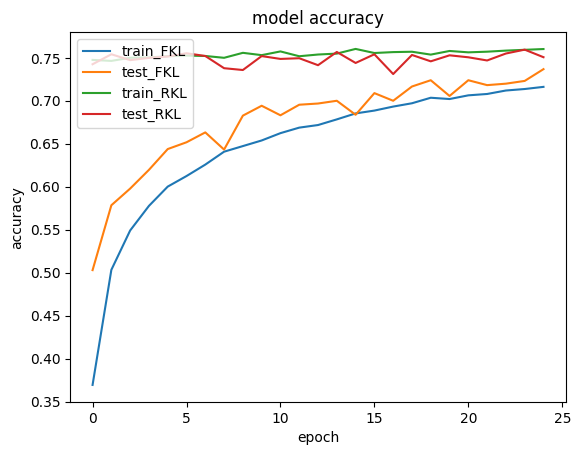

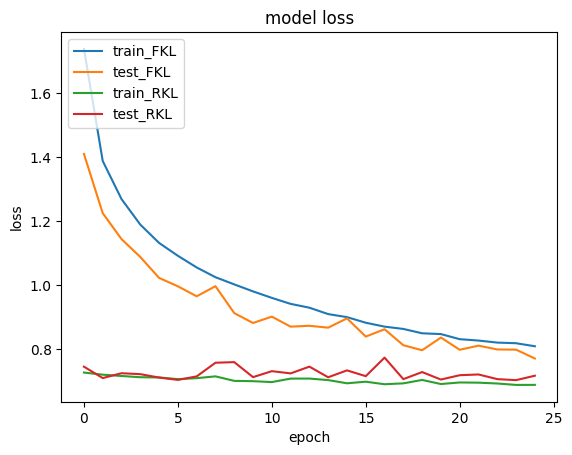

In [ ]:
# redefine the loss function as reverse KL divergence
def my_reverse_KL_loss_fn(y_true, y_pred):
    return tf.reduce_sum(-tf.math.multiply_no_nan(x=y_pred,y=( - tf.math.log(y_pred  + 1e-3) + tf.math.log(y_true + 1e-3) )), axis=-1) # an upper cap of 1e-3 is added in argument of log(y_true) to ensure we don't get NANs from log(0)

# compile the same model with new loss function
model.compile(loss=my_KL_loss_fn,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# train using new loss function
model_history_reverse_KL = model.fit(i_train, o_train,
      batch_size=batch_size,
      epochs=no_epochs,
      verbose=verbosity,
      validation_data=(i_test, o_test),
      validation_split=validation_split
)

import matplotlib.pyplot as plt

# plot old and new accuracies (both forward and reverse KL div.)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.plot(model_history_reverse_KL.history['accuracy'])
plt.plot(model_history_reverse_KL.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_FKL', 'test_FKL', 'train_RKL', 'test_RKL'], loc='upper left')
plt.show()
# plot old and new losses (both forward and reverse KL div.)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.plot(model_history_reverse_KL.history['loss'])
plt.plot(model_history_reverse_KL.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_FKL', 'test_FKL', 'train_RKL', 'test_RKL'], loc='upper left')
plt.show()

References
* https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-kullback-leibler-divergence-kl-divergence-with-keras.md
* https://keras.io/api/losses/probabilistic_losses/#kldivergence-function
* https://www.analyticsvidhya.com/blog/2022/09/dummies-guide-to-writing-a-custom-loss-function-in-tensorflow/
* https://dibyaghosh.com/blog/probability/kldivergence.html